In [1]:
import wfdb


record = wfdb.rdsamp('Datasets/files/04126') 
annotation = wfdb.rdann('Datasets/files/04126', 'atr') 

(0.0, 600.0)

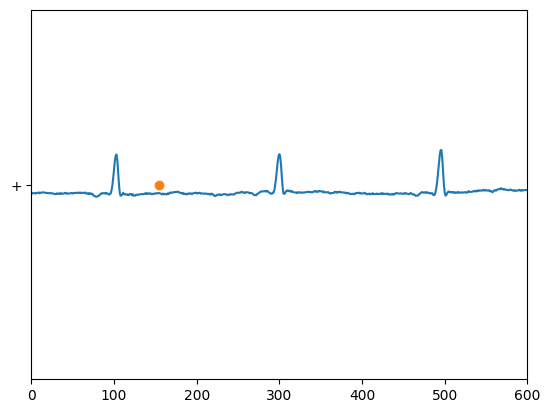

In [2]:
import matplotlib.pyplot as plt

plt.plot(record[0][:,1])
plt.plot(annotation.sample,annotation.symbol, 'o')
plt.xlim(0,600)

In [3]:
record = wfdb.rdsamp('Datasets/files/08378') 
annotation = wfdb.rdann('Datasets/files/08378', 'atr') 

604953
(AFL


(603353.0, 606553.0)

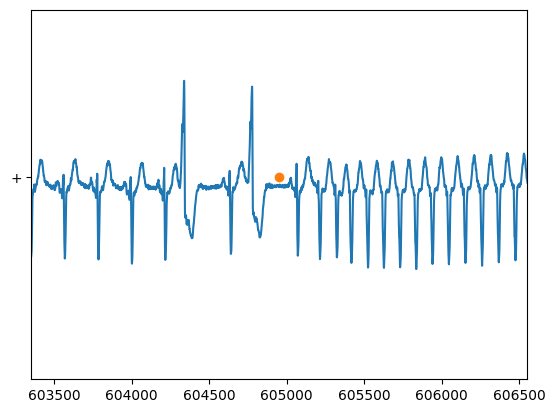

In [4]:
plt.plot(record[0][:,0])
plt.plot(annotation.sample,annotation.symbol, 'o')
print(annotation.sample[1])
print(annotation.aux_note[1])
plt.xlim(603353,606553)

In [56]:
import wfdb.processing
xqrs = wfdb.processing.XQRS(sig=record[0][:,0], fs=250)

xqrs.detect()
qrs_inds = xqrs.qrs_inds
print(xqrs.qrs_inds)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
[    187     395     592 ... 9205102 9205364 9205625]


(604353.0, 605553.0)

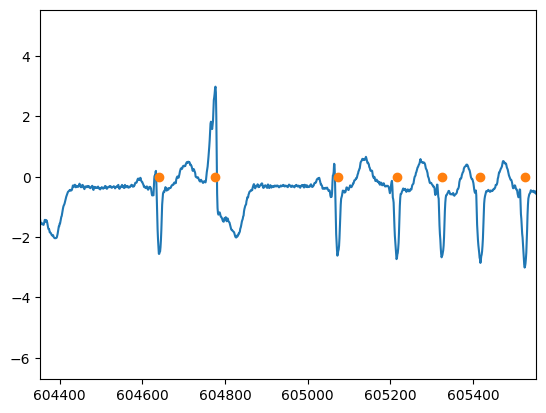

In [57]:
plt.plot(record[0][:,0])
plt.plot(qrs_inds, [0 for i in range(len(qrs_inds))], 'o')
plt.xlim(604353,605553)

In [17]:
rr = wfdb.processing.calc_rr(qrs_inds, fs=250, min_rr=None, max_rr=None, qrs_units='samples',
                                     rr_units='seconds')
print(rr)

[0.832 0.788 0.788 ... 1.044 1.048 1.044]


(603353.0, 606553.0)

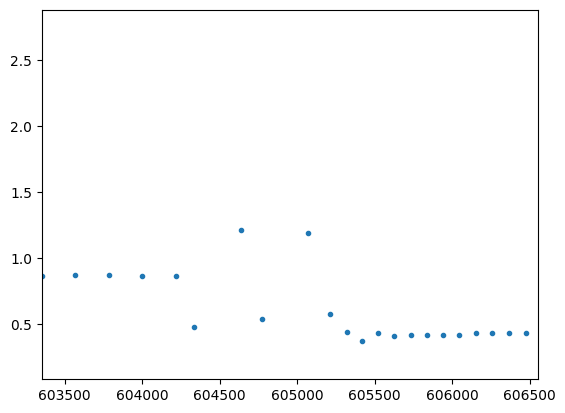

In [22]:
plt.plot(qrs_inds[1:], rr, '.')
plt.xlim(603353,606553)

In [26]:
import wfdb
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
records_A = []
properties_A = []
annot_A = []
AnnSymb_A = []
AnnSamp_A = []
AnnRhythm_A = []
Rpeak_Samp_A = []
Rpeak_Symb_A = []


for f in glob.glob('./Datasets/files/*.dat'):             #### change the path to own directory.       
    sig, fields = wfdb.rdsamp(f[:-4], channels=[0])  #### In this function, pass "channels=[0]" or "channels=[1]" to select channel 1 or 2.
    
    ann = wfdb.rdann(f[:-4], 'atr')
    QRS = wfdb.rdann(f[:-4], 'qrs')
    Symb = pd.Series(ann.symbol)
    Samp = pd.Series(ann.sample)
    
    QRS_Symb = pd.Series(QRS.symbol)
    QRS_Samp = pd.Series(QRS.sample)
    Rhythm = pd.Series(ann.aux_note)
    records_A.append(sig)
    properties_A.append(fields)
    annot_A.append(ann)
    AnnSymb_A.append(Symb)
    AnnSamp_A.append(Samp)
    Rpeak_Symb_A.append(QRS_Symb)
    Rpeak_Samp_A.append(QRS_Samp)
    AnnRhythm_A.append(Rhythm)
    
AnnSymb_A = pd.Series(AnnSymb_A).values
AnnSamp_A = pd.Series(AnnSamp_A).values

In [38]:
appended_AnnSamp = [item for i in range(len(AnnSamp_A)) for item in AnnSamp_A[i]]
appended_AnnSymb = [item for i in range(len(AnnRhythm_A)) for item in AnnRhythm_A[i]]

In [42]:
df = pd.DataFrame(
    {'Rpeaks': appended_AnnSamp,
     'Label': appended_AnnSymb
    })

In [45]:
df

,Rpeaks,Label
0,30,(N
1,102584,(AFIB
2,119604,(N
3,121773,(AFIB
4,122194,(N
...,...,...
600,2606817,(N
601,96,(N
602,2808396,(AFIB
603,2820743,(N


In [46]:
df['Rpeaks'] = round(0.694 * df['Rpeaks'])
df['RRI'] = abs(df['Rpeaks'] - df['Rpeaks'].shift(-1))
df = df.replace(r'^\s*$', np.nan, regex=True) ### Replace empty places with NaN
df = df.fillna(method='ffill') ### Perform "forward fill" - filling instances (NaN) in front row with preceeeding value

arrhythmia_list = ['(N', '(N\x00', '(AFIB', '(AFIB\x00']
final_df = df[df['Label'].isin(arrhythmia_list)]

final_df.loc[df['Label'].astype(str) == '(N\x00', 'Label'] = '(N'
final_df.loc[df['Label'].astype(str) == '(AFIB\x00', 'Label'] = '(AFIB'
final_df = final_df.drop(final_df[final_df.RRI > 1000].index)

final_df['Label'] = final_df['Label'].map( 
                   {'(N':False , '(AFIB':True}) 
final_df['Label'] = final_df['Label'].astype(int)

In [47]:
df

,Rpeaks,Label,RRI
0,21.0,(N,71172.0
1,71193.0,(AFIB,11812.0
2,83005.0,(N,1505.0
3,84510.0,(AFIB,293.0
4,84803.0,(N,7741.0
...,...,...,...
600,1809131.0,(N,1809064.0
601,67.0,(N,1948960.0
602,1949027.0,(AFIB,8569.0
603,1957596.0,(N,20548.0
